# Methodology

Given the flaws in both reports' methodology, it is fair to ask what a better one looks like. 

## The Binomial and Negative Binomial Distributions

As the MST report shows, when a Blaze is killed it almost always drops either zero or one Blaze rod. Both outcomes are equally likely. These drops behave like a Bernoulli process:

1. Some algorithm or thing will "emit" one of two possible outputs, canonically labelled 0 and 1.
2. The choice of which value to emit cannot be predicted beforehand.
3. The current output does not depend on what's been generated before or will be generated later.
4. As the number of values emitted becomes arbitrarily large, the ratio of zeros to ones comes arbitrarily close to a fixed value. That value does not change if we discard an arbitrary number of those outputs.

We can easily simulate that behaviour. Suppose I decided to collect Blaze rods for the first time, and set out to kill six Blazes. Since you can learn little from a single experiment, I do another four Blaze killing sprees.

In [5]:
# Execute this cell to install all dependencies locally
!pip -q install --user mpmath numpy pandas matplotlib scipy

In [6]:
from fractions import Fraction

from math import log,factorial
import matplotlib.pyplot as plt
from mpmath import mp

import numpy as np

import pandas as pd
from scipy.stats import beta,binom,nbinom

dpi = 200    # change this to increase/decrease the resolution charts are made at

In [7]:
# fixing the seed allows for perfect replication
random  = np.random.default_rng(8)

n = 6     # number of Blazes killed
c = 5     # number of runs to kill n Blazes

for experiment in range(c):
    results = random.choice( 2, size=n )
    [print("[Blaze rod] ", end='') if x==1 else print("[ nothing ] ", end='') for x in results]
    print( f"   total = {sum(results)}/{n}" )

[Blaze rod] [ nothing ] [ nothing ] [Blaze rod] [ nothing ] [ nothing ]    total = 2/6
[Blaze rod] [Blaze rod] [Blaze rod] [Blaze rod] [ nothing ] [ nothing ]    total = 4/6
[Blaze rod] [ nothing ] [ nothing ] [ nothing ] [ nothing ] [ nothing ]    total = 1/6
[Blaze rod] [ nothing ] [Blaze rod] [ nothing ] [Blaze rod] [ nothing ]    total = 3/6
[ nothing ] [ nothing ] [ nothing ] [ nothing ] [Blaze rod] [Blaze rod]    total = 2/6


I might calculate my odds of getting exactly three rods by multiplying the odds of getting a rod (50\%) by itself three times, then multiply that by the odds of not getting a rod (50\%) three times. If I carry on that logic for all other possible outcomes and sum them up, however, I find the total probability of all outcomes is $7 \cdot (\frac 1 2)^6 = \frac{7}{64}.$ Those probabilities should sum to one, if I’ve defined a probability distribution.

The error in my logic is that I've failed to account for multiple identical outcomes. Two of the five runs shown above have two total successes, but both earn those successes in a different way. Conversely, there’s only a single way for one of my runs to earn a Blaze rod from every Blaze. To correctly calculate the probability of $k$ drops when killing $n$ Blazes, I need to also calculate the number of ways I could have earned those drops. As luck would have it, the math to do that is pretty easy.

$$
{n \choose k} = \frac{n!}{k!(n-k)!},
$$

where “!” is the factorial function, $n! = n \cdot (n-1) \cdot (n-2) \cdot \dots \cdot 3 \cdot 2$. When I combine those two components, I get the Binomial distribution.

$$
\text{Binom}(n, k, p) = {n \choose k} p^k (1-p)^{n-k} = \frac{n!}{k!(n-k)!} p^k (1-p)^{n-k},
$$ (eqn:binomial)

where $n$ is the number of times the Bernoulli process is sampled, $k$ is the number of 1's emitted, and $p$ is the probability of that Bernoulli process emitting a 1. For my toy example above, we find the odds for $n = 6$, $k = 3$, and $p = \frac 1 2$ are not $\frac 7 {64}$ but instead $\frac 5 {16}$. If I  carry that on for all seven values of $k$ and sum the probabilities, they do indeed add up to one.

In [8]:
def binomial( n, k, p ):
    return Fraction(factorial(n), factorial(k)*factorial(n-k)) * (p**k) * ((1-p)**(n-k))

n = 6
p = Fraction(1,2)

total = sum( binomial(n, k, p) for k in range(n+1) )
print( f'The sum of probabilities of all possible k is {total}', end='' )
if total == Fraction(1,1):
    print( ', which means Binom(n,k,p) defines a probability distribution over k.')
else:
    print( '.' )

The sum of probabilities of all possible k is 1, which means Binom(n,k,p) defines a probability distribution over k.


Suppose I make one tweak to the above scenario, though. This time around I want to earn three Blaze rods, to allow me to craft the six Ender pearls I have in my inventory into six Eyes of Ender.

In [9]:
random  = np.random.default_rng(15)

k = 3     # number of Blaze rods needed
c = 5     # number of runs to earn k Blaze rods

for experiment in range(c):
    results = random.choice( 2, size=16 )
    while np.sum(results) < k:
        results = np.append( results, random.choice( 2, size=16 ) )
    n = np.sum( np.cumsum( results ) < k ) + 1
    [print("[Blaze rod] ", end='') if x==1 else print("[ nothing ] ", end='') for x in results[:n]]
    print( f"   total = {k}/{n}" )

[Blaze rod] [Blaze rod] [Blaze rod]    total = 3/3
[Blaze rod] [ nothing ] [ nothing ] [Blaze rod] [ nothing ] [Blaze rod]    total = 3/6
[ nothing ] [ nothing ] [ nothing ] [ nothing ] [ nothing ] [Blaze rod] [Blaze rod] [Blaze rod]    total = 3/8
[ nothing ] [Blaze rod] [Blaze rod] [Blaze rod]    total = 3/4
[Blaze rod] [ nothing ] [ nothing ] [ nothing ] [Blaze rod] [ nothing ] [Blaze rod]    total = 3/7


Before, I fixed the number of Blazes I killed, $n$, as well as the odds of earning a Blaze rod, $p$, so the only thing that could vary was the number of rods $k$. Now with $k$ and $p$ fixed, $n$ must be the one to vary. That part is obvious, but look carefully at the last Blaze I kill before quitting. Each and every time, it drops a Blaze rod. In hindsight that makes perfect sense: I’ve got no reason to continue killing Blazes after I earn my third rod, after all. In the process, though, I’ve placed some constraints on the number of ways to earn three Blaze rods. The math we invoked earlier to calculate the total number of combinations no longer works.

There is a way to fix it. Rather than consider the full $n$ kills, let’s stop at the $n-1$-th kill. At this point, I have $k-1$ Blaze rods. Since this is Bernoulli process, I have no idea that my next Blaze will net me a rod and I can exit this thought experiment. The $n-1$-th Blaze may or may not have dropped a rod, as of this point all possible ways to earn $k-1$ rods via $n-1$ Blazes are available. There’s only one way to earn that $k$-th rod on my $n$-th, so it doesn’t contribute any new combinations and the total number is ${n-1 \choose k-1}$ instead of ${n \choose k}$.

The probability of getting those rods still works, though. The odds of me getting $k$ rods over $n$ trials with success probability $p$ does not change whether I stop based on $n$ or $k$. Combining this all together, we find the equation that describes the odds of $n$ trials when trying to earn $k$ successes with probability of success $p$ is 

$$
{n-1 \choose k-1} p^k (1-p)^{n-k} = p \cdot \text{Binom}(n-1,k-1,p) = \text{NegBinom}(n,k,p)
$$ (eqn:negbinom)=

This is known as [the Negative Binomial distribution](https://mathworld.wolfram.com/NegativeBinomialDistribution.html). While it's closely related to the Binomial distribution, it is not identical.

## Conjugate Priors

Remember when I mentioned in {ref}`sec:missing_context` that calculating the integrals necessary for Bayesian statistics "is impractical for all but the easiest problems?" Here's one exception: suppose we wish to calculate our credence for the average of a random variable that's distributed according to the [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution). The likelihood function in this case is also a Gaussian distribution. If our prior credence for the average also follows a Gaussian distribution, then our posterior is also a Gaussian distribution. Even better, we can treat the posterior as if it was a prior, apply another Gaussian as a likelihood function to represent new data, and get back another Gaussian posterior that incorporates both the old and new data. Best of all, calculating the mean and standard deviation of the Gaussian posterior is a trivial operation that can be done with elementary school math on a sheet of paper.

When the prior and posterior of a model follow the same distribution, after applying a consistent likelihood function, that prior is called a [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior). These are oases of easy calculation in what is otherwise a Bayesian wasteland of tangled computations. If we can find one applicable here, our analysis will be immensely simpler. The Gaussian example I used above is tempting, as the Gaussian distribution is often used as an approximation of the Binomial, but approximations aren't good enough for what we're aiming for.

Fortunately, the Binomial distribution not only has a conjugate prior, [the Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution), but the updating rule doesn't require a fixed $k$ or $n$. This saves us from having to apply corrections for speedrunners that choose different Blaze rod quotas or happen to pick up Ender pearls outside of bartering. We will need to do some math to convert it to handle the Negative Binomial scenario, however. The updating rule for the Beta conjugate prior is

\begin{align}
\text{Binom}(n,k,p) \cdot \text{Beta}(\alpha_\text{prior}, \beta_\text{prior}, p) &\to \text{Beta}(\alpha_\text{prior} + k, \beta_\text{prior} + n - k, p) \label{eqn:beta_update} \\
\text{Beta}(\alpha, \beta, p) &= \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} p^{\alpha - 1} (1-p)^{\beta - 1} \label{eqn:beta}
\end{align}

where $\Gamma(x)$ is the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function). It is an extrapolation of factorials, such that $n! = \Gamma(n+1)$ for any positive integer $n$. Unlike factorials, though, the Gamma function can be applied to fractions, real numbers, and even complex numbers.

Our next challenge is settling on a prior. There are two in particular that see heavy use, the Bayes/Laplace prior ($\alpha = \beta = 1$) and the Jeffreys prior ($\alpha = \beta = \frac 1 2$). The PE report uses the Bayes/Laplace prior, and given my critique I do not think it is appropriate here. The same reasoning applies to the Jeffreys prior; it groups the credence around $p = 0$ and $p = 1$, both of which are unlikely outcomes whether or not you think cheating was involved.

The prior I recommend instead places the bulk of the credence around the expected drop rate for each item, and spreads the remainder out according to a scaling factor.

In [6]:
def prior(r, scale):
    """Generate an appropriate prior to be used during inference with a Beta conjugate prior.
    
    Parameters
    ----------
    r = The expected rate of item drops, assuming no modification of the game. Must be between 0 and 1.
    scale = A value to scale our credence around r. Higher values favour the hypothesis that
       someone played fairly, while lower values favour someone who cheated. Must be a positive real."""
    
    # ensure the proper values are given
    assert (r > 0) and (r < 1)
    assert scale > 0
    
    if r < .5:
        return (scale, scale*(1-r)/r)
    else:
        return (scale*(1-r)/r, scale)

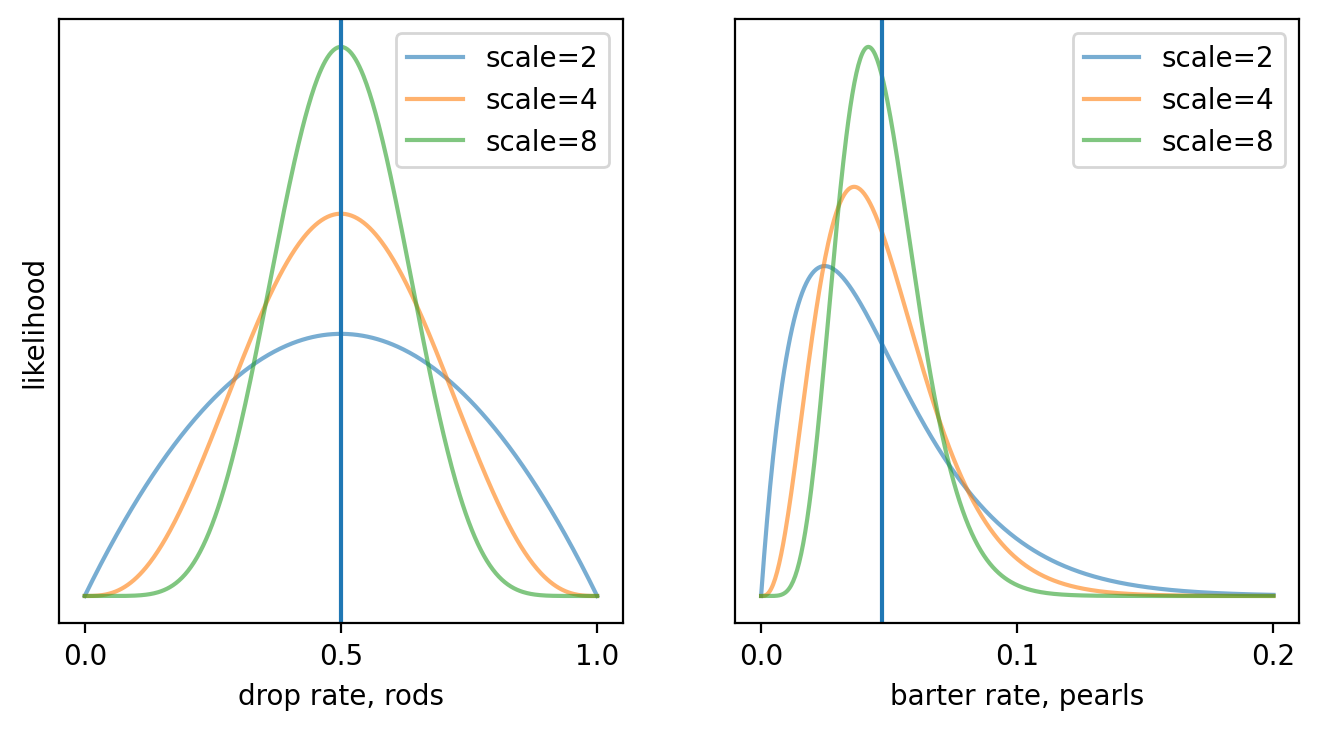

In [7]:
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')
(ax1, ax2) = fig.subplots(1, 2)

x = np.linspace(0,1,512)

scales = [2,4,8]
labels = [f'scale={scale}' for scale in scales]
r_blaze = Fraction(1,2)
r_pearl = Fraction(20,423)

for i,scale in enumerate(scales):

    blaze_prior = [float(x) for x in prior( r_blaze, scale )]
    ax1.plot(x, beta.pdf(x, *blaze_prior), '-', alpha=0.6, label=labels[i] )
    
    pearl_prior = [float(x) for x in prior( r_pearl, scale )]
    ax2.plot(x/5, beta.pdf(x/5, *pearl_prior), '-', alpha=0.6, label=labels[i] )
    

ax1.legend()
ax1.set_xticks([0,.5,1])
ax1.set_xlabel('drop rate, rods')
ax1.set_yticks([])
ax1.set_ylabel('likelihood')
ax1.axvline( r_blaze )

ax2.legend()
ax2.set_xticks([0,.1,.2])
ax2.set_xlabel('barter rate, pearls')
ax2.set_yticks([])
ax2.axvline( r_pearl )

plt.show()

The priors presented in Figure \ref{fig:sub_priors} are all quite subjective, and ask you to make a judgement call on the appropriate scale value to use. I think 4 is a good compromise, but it's simple enough to keep $\alpha_\text{prior}$ and $\beta_\text{prior}$ as free parameters. If you disagree with my choice of Beta prior, you are free to substitute any other. I'll also do a sensitivity analysis where I vary the prior strength with real-world data to help judge how strongly the conclusion is determined by the prior.

The apparent skew on the Ender pearl prior is because we are fixing the mean instead of the maximal likelihood. As we'll be integrating across this prior, fixing the latter would bias us to assume the barter rate is higher.

## The Posterior Distribution for the Binomial and Negative Binomial 

We can now construct a posterior distribution for both the Binomial and Negative Binomial cases. 

The updating rule of Equation \ref{eqn:beta_update} only works for one run of $k$ successes via $n$ trials, distributed according to the Binomial, but it is simple enough to extend for multiple runs. Define $\vec n = \{n_1, n_2, \dots, n_c\}$ as a vector that contains the trial counts for all $c$ runs, and $\vec k = \{v_1, v_2, \dots, v_c\}$ as a vector for each success count. The resulting Beta posterior is

\begin{equation}
\text{Beta}( \alpha_\text{prior} + \sum_{j=1}^c k_j, \beta_\text{prior} + \sum_{j=1}^c (n_j - k_j), p ) = \frac{\Gamma\left(\alpha_\text{prior} + (\sum_{j=1}^c k_j) + \beta_\text{prior} + (\sum_{j=1}^c (n_j - k_j))\right)}{\Gamma(\alpha_\text{prior} + \sum_{j=1}^c k_j)\Gamma(\beta_\text{prior} + \sum_{j=1}^c (n_j - k_j))} p^{\alpha_\text{prior} - 1 + \sum_{j=1}^c k_j} (1-p)^{\beta_\text{prior} - 1 + \sum_{j=1}^c (n_j - k_j)} \label{eqn:beta_binom_mess}
\end{equation}

Equation \ref{eqn:beta_binom_mess} is a bit ugly to look at. One way to clean it up is to use different notation. The [Taxicab norm](https://en.wikipedia.org/wiki/Norm_(mathematics)#Taxicab_norm_or_Manhattan_norm) is defined as

\begin{equation}
\|\vec n\|_1 = \sum_{j=1}^c |n_j|,
\end{equation}

and since no value contained by $\vec n$ or $\vec k$ are negative this substitution won't screw up the math. Note as well that

\begin{equation}
\sum_{j=1}^c (n_j - k_j) = \left(\sum_{j=1}^c n_j\right) - \left(\sum_{j=1}^c k_j\right) = \|\vec n\|_1 - \|\vec k\|_1,
\end{equation}

which, along with $\|\vec k\|_1 + \|\vec n\|_1 - \|\vec k\|_1 = \|\vec n\|_1$, allows us to rewrite Equation \ref{eqn:beta_binom_mess} as

\begin{equation}
\text{Beta}( \alpha_\text{prior} + \|\vec k\|_1, \beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1, p ) = \frac{\Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1)}{\Gamma(\alpha_\text{prior} + \|\vec k\|_1)\Gamma(\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1))} p^{\alpha_\text{prior} + \|\vec k\|_1 - 1} (1-p)^{\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1 - 1)} \label{eqn:beta_binom_post}
\end{equation}

There's no need to normalize Equation \ref{eqn:beta_binom_post} to make it a probability distribution over $p$, as

\begin{equation}
\int_{p=0}^1 \text{Beta}(\alpha, \beta, p) = 1 \label{eqn:beta_integral}
\end{equation}

and therefore it is already normalized. That handles the case when $\vec k$ and $\vec n$ are taken from a Binomial distribution. What about the Negative Binomial case? Equation \ref{eqn:negbinom} shows the Negative Binomial is simply the Binomial times the probability of success, so in theory some math would give us a solution specifically tailored to the Negative Binomial. Unfortunately, that equation also shows the Negative Binomial isn't a probability distribution with respect to $p$.

In [8]:
n = 6
k = 3

# mp.quad() uses quadrature to numerically integrate. No math necessary on our side!
result = mp.quad( lambda p: p*binomial(n, k, p), (0,1) )

print( f'The integral of all possible p is {result}', end='' )
if result == Fraction(1,1):
    print( ', which means p*Binom(n,k,p) defines a probability distribution over p.')
else:
    print( '.' )

The integral of all possible p is 0.0714285714285714.


It is actually a probability distribution with respect to $n$. We must normalize it to create a true posterior, and the best time to do so is after extending the updating rule. First, observe that

\begin{align}
\sum_{j=1}^c (n_j - 1) &= \left(\sum_{j=1}^c n_j\right) - c = \|\vec n\|_1 - c \\
(\|\vec n\|_1 - c) - (\|\vec k\|_1 - c) &= \|\vec n\|_1 - \|\vec k\|_1,
\end{align}

and secondly, observe that we can rearrange the order we multiply without changing the final product. This allows us to write

\begin{align}
\text{posterior}_\text{Negative Binomial} &= p^c \left( \left( \prod_{j=1}^c \text{Binom}(n_j - 1, k_j - 1, p) \right)  \text{Beta}(\alpha_\text{prior}, \beta_\text{prior}, p) \right) \\
{} &= p^c \text{Beta}( \alpha_\text{prior} + \|\vec k\|_1 - c, \beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1, p ) \\
{} &= p^c \frac{\Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1 - c)}{\Gamma(\alpha_\text{prior} + \|\vec k\|_1 - c)\Gamma(\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1)}p^{\alpha_\text{prior} + \|\vec k\|_1 - c - 1}(1-p)^{\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1 - 1}
\end{align}

We can tidy that up a bit, as $p^a \cdot p^b = p^{a + b}$ and $c - c = 0$.

\begin{equation}
{} = \frac{\Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1 - c)}{\Gamma(\alpha_\text{prior} + \|\vec k\|_1 - c)\Gamma(\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1)}p^{\alpha_\text{prior} + \|\vec k\|_1 - 1}(1-p)^{\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1 - 1} \label{eqn:negbinom_unnormed}
\end{equation}

To normalize Equation \ref{eqn:negbinom_unnormed} according to $p$, we only need to divide it by integrating across $p$.

\begin{equation}
\int_{p=0}^1 \frac{\Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1 - c)}{\Gamma(\alpha_\text{prior} + \|\vec k\|_1 - c)\Gamma(\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1)}p^{\alpha_\text{prior} + \|\vec k\|_1 - 1}(1-p)^{\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1 - 1}
\end{equation}

Note that all the Gamma functions are unaffected by any change in $p$. As $\int_x c \cdot g(x) = c \int_x g(x)$, we can pull them out of the integral. Since the same value is present in the numerator, all the Gamma functions cancel and we are left with

\begin{equation}
\int_{p=0}^1 p^{\alpha_\text{prior} + \|\vec k\|_1 - 1}(1-p)^{\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1 - 1}
\end{equation}

to evaluate. While this may seem daunting, remember that the Beta distribution integrates to 1 across $p$. Thus we can exploit the prior trick to rearrange Equation \ref{eqn:beta_integral}, and find

\begin{align}
\int_{p=0}^1 \text{Beta}(\alpha, \beta, p) &= 1 \\
\int_{p=0}^1 \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} p^{\alpha-1}(1-p)^{\beta-1} &= 1 \\
\int_{p=0}^1 p^{\alpha-1}(1-p)^{\beta-1} &= \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)} \label{eqn:beta_trick}
\end{align}

Equation \ref{eqn:beta_trick} will be incredibly handy in future, but for now it allows us to finish normalizing Equation \ref{eqn:negbinom_unnormed}.

\begin{align}
\alpha - 1 &= \alpha_\text{prior} + \|\vec k\|_1 - 1 \\
\alpha &= \alpha_\text{prior} + \|\vec k\|_1 \\
\beta &= \beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1 \\
\text{posterior}_\text{Negative Binomial} &= \frac{p^{\alpha_\text{prior} + \|\vec k\|_1 - 1}(1-p)^{\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1 - 1}}{\frac{\Gamma(\alpha_\text{prior} + \|\vec k\|_1 )\Gamma(\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1)}{\Gamma(\alpha_\text{prior} + \beta_\text{prior} \|\vec n\|_1)} } \\
{} &= \frac{\Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1)}{\Gamma(\alpha_\text{prior} + \|\vec k\|_1)\Gamma(\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1)} p^{\alpha_\text{prior} + \|\vec k\|_1 - 1} (1-p)^{\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1 - 1} \label{eqn:beta_negbinom_post}
\end{align}

This is identical to Equation \ref{eqn:beta_binom_post}.\footnote{This is also why I didn't bother showing the derivation of the Beta update rule: calculating $\text{Binom}(n,k,p) \cdot \text{Beta}(\alpha, \beta, p)$ is trivially harder than $p \cdot Beta(\alpha, \beta, p)$, and the renormalization process is exactly the same. The extension from $k$ and $n$ to $\vec k$ and $\vec n$ is also trivial.} The PE report was correct to raise the possibility that barters and drops do not follow the Binomial distribution (pg. 7), but an analyis that used the Negative Binomial instead would come to the same conclusion. The MST report is also incorrect when they state that the Binomial distribution is "a very good approximation" (pg. 10) for barters/drops, in reality it leads to the exact same outcome as assuming the Negative Binomial instead.

The posterior from Equation \ref{eqn:beta_negbinom_post} is worth seeing in action. We'll apply it to the toy example from Listing \ref{code:negbinom_exam}, using the prior I defined earlier.

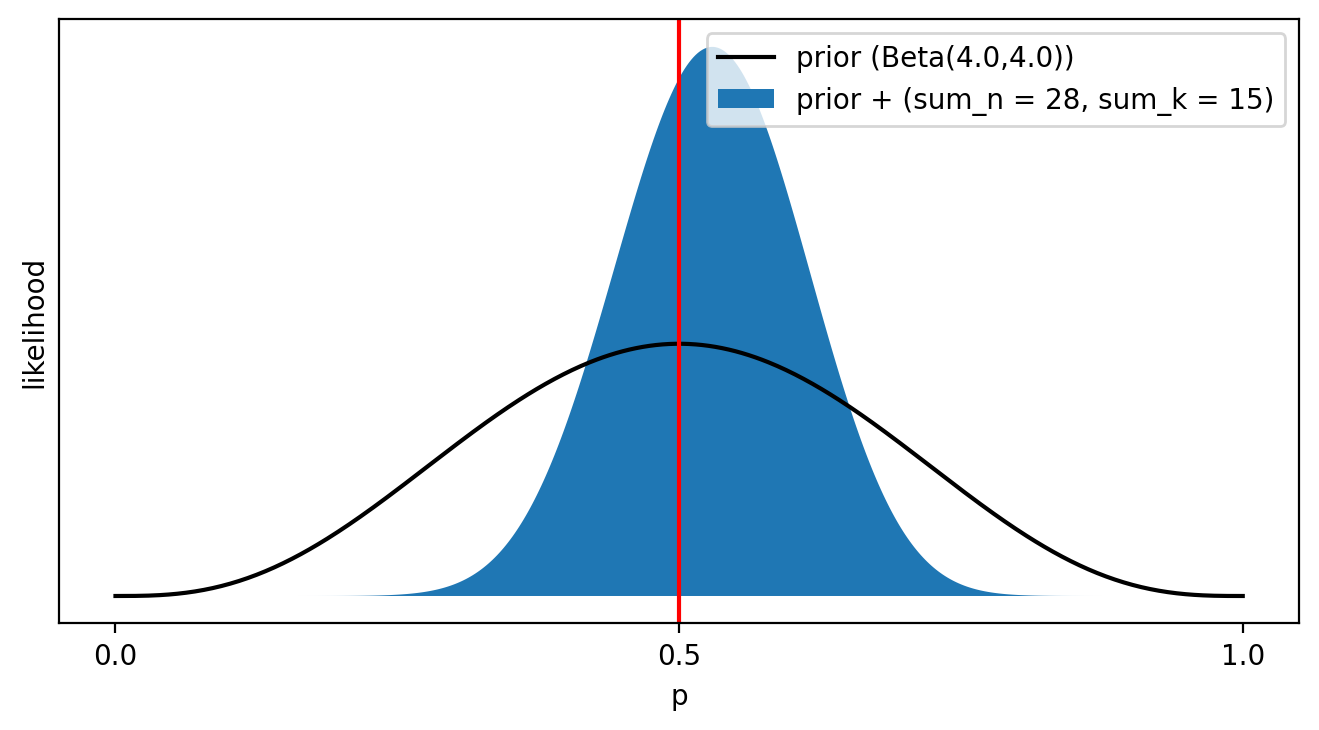

In [9]:
random  = np.random.default_rng(15)

k = 3     # number of Blaze rods needed
c = 5     # number of runs to earn k Blaze rods

sum_k = k * c  # we already know this
sum_n = 0

for experiment in range(c):
    results = random.choice( 2, size=16 )
    while np.sum(results) < k:
        results = np.append( results, random.choice( 2, size=16 ) )
    sum_n += np.sum( np.cumsum( results ) < k ) + 1

my_prior = prior(0.5, 4)
    
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

x = np.linspace(0,1,512)
plt.fill_between( x, beta.pdf( x, my_prior[0] + sum_k, my_prior[1] + sum_n - sum_k), linestyle='-',
                label=f'prior + (sum_n = {sum_n}, sum_k = {sum_k})')

plt.plot( x, beta.pdf( x, my_prior[0], my_prior[1]), '-k', \
         label=f'prior (Beta({my_prior[0]:.1f},{my_prior[1]:.1f}))')
plt.axvline( 0.5, color='red' )

plt.xticks([0,.5,1])
plt.xlabel('p')

plt.yticks([])
plt.ylabel('likelihood')

plt.legend()
plt.show()

Figure \ref{fig:posterior_in_action} holds few surprises. Our credence over the Blaze rod drop rate began quite diffuse with the prior. Adding the simulation data grouped our credence more tightly together, making extremely low or high drop rates very unlikely. At the same time, the limited evidence allows drop rates close to $p = 0.5$ to remain very credible, and thanks to the nature of randomness the maximally likely drop rate of the posterior is not the actual value.

## Defining Fairness

Presenting a range of credible values isn't sufficient, as we have a specific hypothesis to test. The words "did Dream cheat?" do not have an obvious mathematical interpretation, but some interpretations are superior to others.

The easiest way to start is not by defining cheating, but instead defining fair play. We know unaltered Minecraft code sets the drop rate to 0.5, so why not define fairness by $\text{Beta}( \alpha_\text{posterior}, \beta_\text{posterior}, 0.5)$?

In [10]:
print( 'The likelihood I was playing fair in my simulation is' +
      f' {beta.pdf( 0.5, my_prior[0] + sum_k, my_prior[1] + sum_n - sum_k)} .')

The likelihood I was playing fair in my simulation is 4.490060385433022 .


The most glaring problem is that the output of the posterior is a likelihood, which isn't normalized like a probability is. We need to find some way to scale or modify that value so that it maps to something more meaningful to us.

But there's a more subtle problem here. Imagine an idealized dart board, centered at the origin of a 2D cartesian plane and with radius 1. Now pick a point on that dart board, and ask yourself the odds of an ideal dart hitting that point. The answer must be zero: since the dart board contains an [uncountably infinite](https://mathworld.wolfram.com/UncountablyInfinite.html) number of points, the odds of a dart hitting any one point is zero. Since the point we chose was arbitrary, we must conclude the odds of an ideal dart hitting our ideal dart board are zero. And yet clearly an ideal dart cast at that board must hit some point.

The solution is not to work with infinitely small points, but instead areas. If we expand the point in question to encompass a finite area, the probability becomes non-zero. Likewise, I could collect Blaze rods in Minecraft until the day I die, and the odds of me getting an exact 50\% drop rate would be incredibly small even if I was playing with an unmodified version of Minecraft. Instead, when assessing fairness we should consider a range of possible drop rates. Where do we place the ends of the range, however?

One possibility comes from coin flipping. That process has been considered fair for a long time, and is often relied on as a source of randomness. One researcher decided to test how fair a coin toss actually is, by asking medical residents to try biasing their coin flips in order to earn a \$20 prize. They were given a few weeks' notice before they were asked to flip a coin 300 times.

> This study shows that when participants are given simple instructions about how to manipulate the toss of a coin and only a few minutes to practise this technique, more than half can significantly manipulate the outcome. With devoted training, more participants would probably be able to achieve this figure, and the magnitude of the manipulation would probably be increased.\cite{ClarkE306}

One way to reconcile these two observations is to essert that a coin toss is "fair enough." Even if it is easy to bias a coin toss, the amount of bias may not be enough to matter in the context of where coin tosses are used. If we take the average bias of coin tosses in this study as our "fair enough" threshold, then fair constitutes no more than an $\frac{569}{500}$ improvement in the odds over perfect fairness, or in this case a success rate of 56.9\%. We could express that in mathematics as

\begin{equation}
\int_{p=0.431}^{0.569} \text{Beta}(\alpha_\text{posterior}, \beta_\text{posterior}, p)
\end{equation}

This definition also has problems, though. Suppose I decided to modify my copy of Minecraft so that Blaze rods dropped 53\% of the time. In the short run this is quite undetectable, but what happens when I do 200 runs where I target seven Blaze rods.

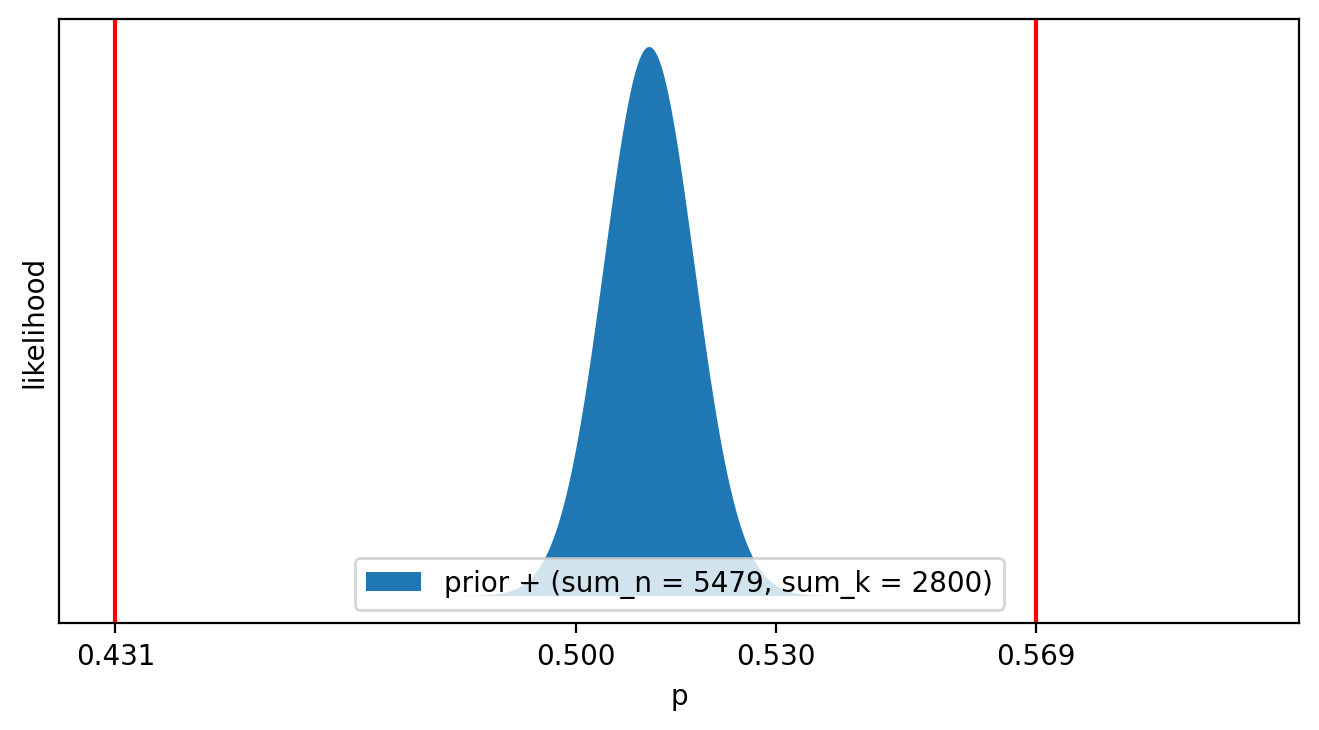

In [11]:
random  = np.random.default_rng(26)

k = 7     # number of Blaze rods needed
c = 400   # number of runs to earn k Blaze rods

sum_k = k * c  # we already know this
sum_n = sum_k + np.sum(random.negative_binomial( k, 0.52, size=c ))

my_prior = prior(0.5, 4)
    
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

x = np.linspace(.45,.6,512)
plt.fill_between( x, beta.pdf( x, my_prior[0] + sum_k, my_prior[1] + sum_n - sum_k), linestyle='-',
                label=f'prior + (sum_n = {sum_n}, sum_k = {sum_k})')

plt.axvline( 0.431, color='red' )
plt.axvline( 0.569, color='red' )

plt.xticks([.431, .5,.53,.569])
plt.xlabel('p')

plt.yticks([])
plt.ylabel('likelihood')

plt.legend()
plt.show()

The posterior in Figure \ref{fig:fixed_fairness_bad} appears to provide strong evidence that I altered my drop rate,  as little credence is massed around $p = \frac 1 2$. Yet almost all of the credence lies within the bounds of integration, so our integral's value would be little different than if the mass had been much more clustered around the halfway mark. $H_\text{fair}$ don't just need to integrate over a range, its must "tighten up" as more data arrives.

Consider a version of Minecraft that swapped out the pseudo-random number generator with a sophisticated deterministic algorithm. This could detect the number of Blaze rods I want over the time period I'm playing, and automatically ensure exactly half of the Blazes I kill will drop Blaze rods. If I fed this fair algorithm into the math and generated a posterior, for the $\|\vec n\|_1 = 28$ case I would get

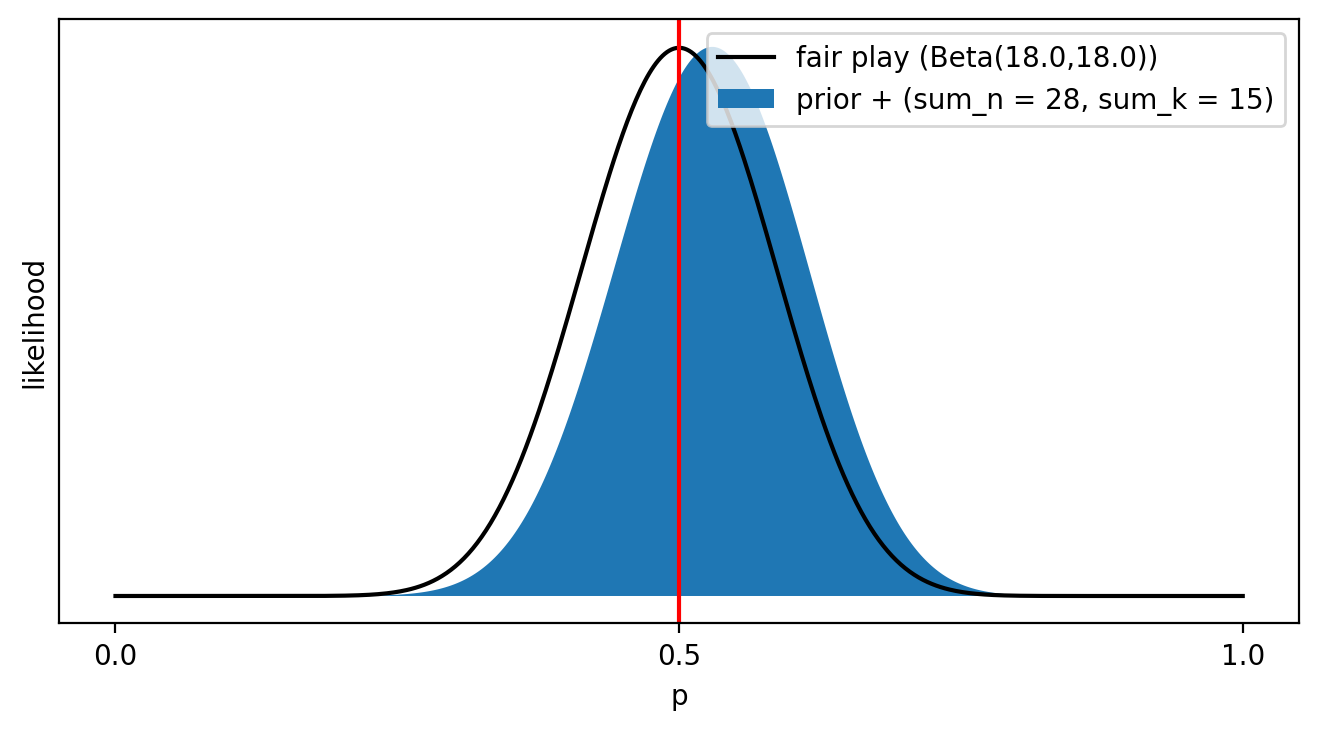

In [12]:
random  = np.random.default_rng(15)

k = 3     # number of Blaze rods needed
c = 5     # number of runs to earn k Blaze rods

sum_k = k * c  # we already know this
sum_n = 0

for experiment in range(c):
    results = random.choice( 2, size=16 )
    while np.sum(results) < k:
        results = np.append( results, random.choice( 2, size=16 ) )
    sum_n += np.sum( np.cumsum( results ) < k ) + 1

my_prior = prior(0.5, 4)
    
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

x = np.linspace(0,1,512)
plt.fill_between( x, beta.pdf( x, my_prior[0] + sum_k, my_prior[1] + sum_n - sum_k), linestyle='-',
                label=f'prior + (sum_n = {sum_n}, sum_k = {sum_k})')

plt.plot( x, beta.pdf( x, my_prior[0] + sum_n/2, my_prior[1] + sum_n/2), '-k', \
         label=f'fair play (Beta({my_prior[0] + sum_n/2:.1f},{my_prior[1] + sum_n/2:.1f}))')
plt.axvline( 0.5, color='red' )

plt.xticks([0,.5,1])
plt.xlabel('p')

plt.yticks([])
plt.ylabel('likelihood')

plt.legend()
plt.show()

I consider this a really good match for $H_\text{fair}$, as it nicely satisfies all the above requirements. You might have thought of a problem, though: what if I'd killed 27 Blazes instead of 28? Or, to take a more extreme example, if your copy of Minecraft 1.16.1 is unmodified you'll get 20 Ender pearl barters on 423 attempts. Those two numbers are co-prime, so the number of successful pearl barters will only be an integer so long as the number of attempts is a multiple of 423. It would be terribly inconvenient if we had to wait for 423 barters before we could start our analysis.

This is where the Gamma function really shines, as it's defined for fractions. When calculating $H_\text{fair}$ for Ender pearl barters, we're not forced to assign 20 successes for every 423 barters, we can instead assign $\frac{20}{423}$ successes for every barter. $H_\text{fair}$ is defined for arbitrary numbers of barters or drops.

Let's lock the mathematics for $H_\text{fair}$ down.

\begin{equation}
H_\text{fair}( p ~|~ \|\vec n\|_1 ) = \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|\vec n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1, p ), \label{eqn:h_fair}
\end{equation}

where $r_\text{fair}$ is the rate we expect during fair play. For instace, $r_\text{blaze} = \frac 1 2$ and $r_\text{pearl} = \frac{20}{423}$.

If you do not agree with my definition of "fair play" according to Equation \ref{eqn:h_fair}, I'd encourage you to think up your own and express it in a mathematically precise way. In the meantime, I'll multiply $H_\text{fair}(\vec n)$ by the posterior and integrate.

\begin{equation}
\int_{p=0}^1 \text{Beta}(\alpha_\text{posterior}, \beta_\text{posterior}, p ) H_\text{fair}( \vec n, p ) = \int_{p=0}^1 \text{Beta}( \alpha_\text{prior} + \|\vec k\|_1 , \beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1, p ) \cdot \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|\vec n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1, p )
\end{equation}

\begin{equation}
{} = \int_{p=0}^1 \frac{\Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1)}{\Gamma(\alpha_\text{prior} + \|\vec k\|_1)\Gamma(\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1)} p^{\alpha_\text{prior} + \|\vec k\|_1 - 1} (1-p)^{\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1 - 1} \frac{\Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1)}{\Gamma(\alpha_\text{prior} + r_\text{fair}\|\vec n\|_1)\Gamma(\beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1)} p^{\alpha_\text{prior} + r_\text{fair}\|\vec n\|_1 - 1} (1-p)^{\beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1 - 1} 
\end{equation}

\begin{equation}
{} = \frac{\Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1)^2}{\Gamma(\alpha_\text{prior} + \|\vec k\|_1)\Gamma(\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1)\Gamma(\alpha_\text{prior} + r_\text{fair}\|\vec n\|_1)\Gamma(\beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1)} \int_{p=0}^1  p^{2 \alpha_\text{prior} + \|\vec k\|_1 + r_\text{fair}\|\vec n\|_1 - 2} (1-p)^{2 \beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1  + (1-r_\text{fair})\|\vec n\|_1 - 2}
\end{equation}

\begin{equation}
\|\vec n\|_1 + (1-r_\text{fair})\|\vec n\|_1 = (2 -r_\text{fair})\|\vec n\|_1
\end{equation}

\begin{equation}
\int_{p=0}^1  p^{2 \alpha_\text{prior} + \|\vec k\|_1 + r_\text{fair}\|\vec n\|_1 - 2} (1-p)^{2 \beta_\text{prior} + - \|\vec k\|_1  + (2-r_\text{fair})\|\vec n\|_1 - 2} = \frac{\Gamma(2 \alpha_\text{prior} + \|\vec k\|_1 + r_\text{fair}\|\vec n\|_1 - 1)\Gamma(2 \beta_\text{prior} - \|\vec k\|_1  + (2-r_\text{fair})\|\vec n\|_1 - 1)}{\Gamma(2 \alpha_\text{prior} + 2 \beta_\text{prior} + 2\|\vec n\|_1 - 2)}
\end{equation}

\begin{equation}
{} = \frac{\Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1)^2 \Gamma(2 \alpha_\text{prior} + \|\vec k\|_1 + r_\text{fair}\|\vec n\|_1 - 1)\Gamma(2 \beta_\text{prior} - \|\vec k\|_1  + (2-r_\text{fair})\|\vec n\|_1 - 1) }{\Gamma(\alpha_\text{prior} + \|\vec k\|_1)\Gamma(\beta_\text{prior} + \|\vec n\|_1 - \|\vec k\|_1)\Gamma(\alpha_\text{prior} + r_\text{fair}\|\vec n\|_1)\Gamma(\beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1)\Gamma(2 \alpha_\text{prior} + 2 \beta_\text{prior} + 2\|\vec n\|_1 - 2)} \label{eqn:posterior_h_fair}
\end{equation}

Equation \ref{eqn:posterior_h_fair} isn't as tidy as we'd hoped, but at least that integral is gone. Evaluating it looks very difficult, but I have an ace up my sleeve. `mpmath` is a Python library that allows you to do calculations with arbitrary precision. This is handy when dealing with very large numbers, because with conventional floating-point math there's a chance you could overflow and have everything break. One function in that library, `mpmath.gammaprod()`, allows you to calculate fractions with arbitrary numbers of Gamma functions in the numerator or denominator. It makes evaluating messes like Equation \ref{eqn:posterior_h_fair} a snap. Let's fix $\|\vec n\|_1 = 28$ and $r_\text{fair} = \frac 1 2$, apply my prior of $\alpha_\text{prior} = \beta_\text{prior} = 4$, and see what we get for all possible values of $\|\vec k\|_1$.

In [13]:
def posterior_H_fair( vec_k, vec_n, r_fair, a_prior, b_prior ):
    """Calculate the likelihood of H_fair, given the posterior distribution defined by vec_n, vec_k, and the prior.
        Relies on mpmath to perform all calculations, which also means you can adjust the precision.
    
    Parameters
    ----------
    vec_k: A total or list containing the successful attempts at this task until it was completed.
    vec_n: A total or list containing the total attempts at this task until it was completed.
    r_fair: A float between 0 and 1 representing the probability of success predicted by H_fair.
    a_prior: A positive or zero float representing the alpha variable of the prior.
    b_prior: A positive or zero float representing the beta variable of the prior.
    
    Returns
    -------
    The likelihood, an mpmath float in the range [0,infinity]."""

    # place some imports here to encourage copy-paste coding
    from mpmath import gammaprod
    from numpy import sum        # vectorized, likely faster than Python's sum
    
    # the downside of encouraging copy-pasting is that this code will face some
    #  dirty/invalid inputs. By going wild with asserts, I'm making it tougher to
    #  use this function inappropriately.
    assert (r_fair > 0) and (r_fair < 1)
    assert (a_prior >= 0) and (b_prior >= 0)
    
    # use duck typing to determine whether these are lists or not
    try:
        len_k = len(vec_k)
        k_is_list = True
    except TypeError:
        len_k = 1
        k_is_list = False

    try:
        len_n = len(vec_n)
        n_is_list = True
    except TypeError:
        len_n = 1
        n_is_list = False
   
    # do additional checks if both are lists
    if k_is_list and n_is_list:
        
        assert len_k == len_n
        for i,n in enumerate(vec_n):
            assert n > 0
            assert (vec_k[i] >= 0) and (vec_k[i] <= n)
                  
    # now calculate sums      
    if k_is_list:
        sum_k = sum(vec_k)
    else:
        sum_k = vec_k
        
    if n_is_list:
        sum_n = sum(vec_n)
    else:
        sum_n = vec_n
        
    # one final round of checks
    assert sum_n >= 1
    assert (sum_k >= 0) and (sum_k <= sum_n)

    # calculate the final result
    numerator =   [a_prior + b_prior + sum_n, a_prior + b_prior + sum_n,
                  2*a_prior + sum_k + r_fair*sum_n - 1,
                  2*b_prior - sum_k + (2 - r_fair)*sum_n - 1]
    denominator = [a_prior + sum_k, b_prior + sum_n - sum_k,
                   a_prior + r_fair*sum_n, b_prior + (1 -r_fair)*sum_n,
                  2*(a_prior + b_prior + sum_n - 1)]
    
    return gammaprod(numerator, denominator)

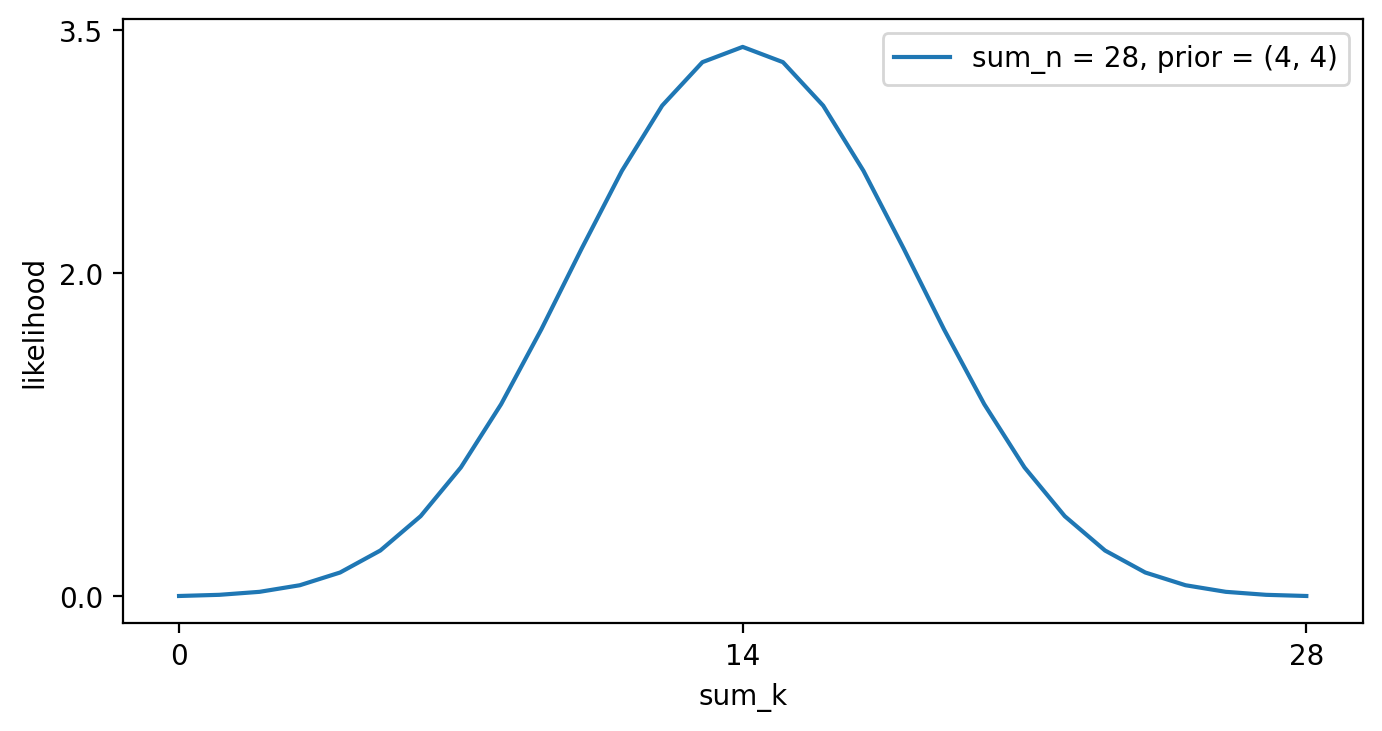

In [14]:
sum_n  = 28
r_fair = Fraction(1,2)
a_prior, b_prior = prior( r_fair, 4 )


fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

x = np.arange(sum_n + 1)
plt.plot( x, [posterior_H_fair( v, sum_n, r_fair, a_prior, b_prior ) for v in x], '-', \
        label=f'sum_n = {sum_n}, prior = ({a_prior}, {b_prior})')

plt.ylabel("likelihood")
plt.yticks([ 0, 2, 3.5 ])

plt.xlabel('sum_k')
plt.xticks([ 0, 14, 28 ])

plt.legend()
plt.show()

Figure \ref{fig:posterior_H_fair} behaves much as we'd expect. $H_\text{fair}$ is maximized when $\|\vec k\|_1 = r_\text{fair}\|\vec n\|_1$, remains quite high for nearby values, but rapidly drops off as $\|\vec k\|_1$ diverges.

## Defining a Reference Point

Figure \ref{fig:posterior_H_fair} also demonstrates that we're still dealing with raw likelihoods. We still need that reference point.

The usual solution is to calculate a Bayes factor. You've likely seen Bayes' Theorem,

\begin{equation}
p( H_1 | E ) = \frac{p( E | H_1 ) p( H_1 )}{p(E)}
\end{equation}

The likelihood function $p( E | H_1 )$ and prior $p( H_1 )$ should be familiar enough by now. The normalization factor $p( E )$ is the probability of observing the evidence over all possible hypotheses. We've managed to avoid it by invoking conjugate priors, specifically by starting with a prior that's universal to all hypotheses worthy of consideration. Once we apply a specific hypothesis, or use another method of calculation, $p( E )$ becomes non-trivial to calculate.

The ideal solution is to define a second hypothesis, say $H_2$, and divide.

\begin{equation}
\frac{p( H_1 | E )}{p( H_2 | E )} = \frac{p( E | H_1 ) p( H_1 )}{p( E | H_2 ) p( H_2 )} \label{eqn:bayes_factor}
\end{equation}

This "Bayes factor" eliminates the need to calculate $p(E)$, and constants across the numerator ond denominator cancel out so computation is easier. It has the same interpretation as betting odds, with numbers greater than 1 indicating $H_1$ is favoured and vice-versa. It also has none of the flaws of p-values, for instance it obeys all the properties of a likelihood so combining multiple Bayes factors together is as simple as multiplying them.

In this context, the only worthwhile second hypothesis is "did Dream cheat?". Unfortunately, while there's only one $r_\text{fair}$ there are many ways to cheat. Ideally we'd consult with experts about Minecraft speedrunning and develop a mathematically-precise hypothesis about what cheating looks like. Since I do not have those connections, I'll use a backup strat.

If we accept my definition of $H_\text{fair}$, we can define $H_\text{cheat}$ as the inverse of that definition; where $H_\text{fair}$ asserts fair play is likely, $H_\text{cheat}$ asserts it is unlikely, and vice-versa. The easiest way to accomplish that is to subtract the likelihood output by $H_\text{fair}$ from some other value. This value must be high enough to prevent the result from ever being negative, and not so high that it waters down the negation of $H_\text{fair}$. The obvious choice is to use the maximal likelihood of $H_\text{fair}$ as that value, which is

\begin{align}
m_\text{fair} &= \frac{\alpha - 1}{\alpha + \beta - 2} = \frac{\alpha_\text{prior} + r_\text{fair}\|\vec n\|_1 - 1}{\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1 - 2} \\
M_\text{fair} &= \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|\vec n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1, m_\text{fair})
\end{align}

There are three flaws with using $M_\text{fair} - H_\text{fair}$ as $H_\text{cheat}$. This hypothesis gives maximal credence to both $p = 0$ and $p = 1$, and yet no cheater would dare set their probability of success to those values. Fortunately, my choice to go with a subjective prior already factored that in. If you go with another prior, either alter it the same way or adjust $M_\text{fair} - H_\text{fair}$ appropriately.

This hypothesis also states that if $\|\vec k\|_1 = r_\text{fair}\|\vec n\|_1$, the likelihood of cheating is zero. Yet we can easily concoct scenarios where a run of bad luck happens to result in a record that appears perfectly fair. In comparison, $H_\text{fair}$ has no zeros except at $p = 0$ and $p = 1$. A better alternative is to add some small offset to model to capture the small but ever present possibility of cheating by unknown means. For the same reason $H_\text{fair}$ scales with $\|\vec n\|_1$, it would be wise to scale this offset by the inverse of that value.

I propose $\frac 1 2 \|\vec n\|_1^{-1}$ is a good choice. Consider an ideal Bernouilli process representing evidence towards some hypothesis. As we know nothing about this process, "non-informative" priors\footnote{The scare quotes are because there's a strong argument to be made all priors leak information into the posterior, as what we consider "uninformative" according to one parameterization may not be the same with another.\cite{syversveen1998noninformative} It's better to aim for weakly-informative than non-informative.} make more sense than a subjective one. What I consider to be the best-justified "non-informative" prior is the Jeffrey's prior, which in this case is $\text{Beta}(\frac 1 2, \frac 1 2)$. If all $\|\vec n\|_1$ atoms of evidence pulled from this process goes against the hypothesis, the mean value for the probability of truth $p$ is

\begin{equation}
\frac{ \frac 1 2 }{ \frac 1 2 + \|\vec n\|_1} \approx \frac 1 {2\|\vec n\|_1}
\end{equation}

I can keep the constant factor separate, so if you do not agree with it you can supply an alternative or eliminate the offset entirely by setting the constant to zero.

Third and finally, $M_\text{fair} - H_\text{fair} + \frac 1 2 \|\vec n\|_1^{-1}$ is not normalized when integrated by $p$, a requirement if we're to compare it against $H_\text{fair}$. This is quite simple, as

\begin{align}
\int \left( g(x) + h(x) \right) &= \left( \int g(x) \right) + \left( \int h(x) \right) \\
\int_{p=0}^1 t &= \left. t\cdot p \right|_{p=0}^1 = t\cdot(1) - t\cdot(0) = t
\end{align}

so therefore

\begin{align}
\int_{p=0}^1 M_\text{fair} - \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|\vec n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1, p ) + \frac 1 {2 \|\vec n\|_1} &= M_\text{fair} + \frac 1 {2 \|\vec n\|_1} - 1
\end{align}

and we can finally write out $H_\text{cheat}$.

\begin{align}
H_\text{cheat}( p ~|~ \|\vec n\|_1, r_\text{fair} ) &= \frac{ M_\text{fair} + \frac 1 {2 \|\vec n\|_1} - \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|\vec n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1, p) }{M_\text{fair} + \frac 1 {2 \|\vec n\|_1} - 1}, \label{eqn:H_cheat} \\
M_\text{fair} &= \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|\vec n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1, m_\text{fair}) \\
m_\text{fair} &= \frac{\alpha_\text{prior} + r_\text{fair}\|\vec n\|_1 - 1}{\alpha_\text{prior} + \beta_\text{prior} + \|\vec n\|_1 - 2}
\end{align}

For the toy example above, Equation \ref{eqn:H_cheat} looks like

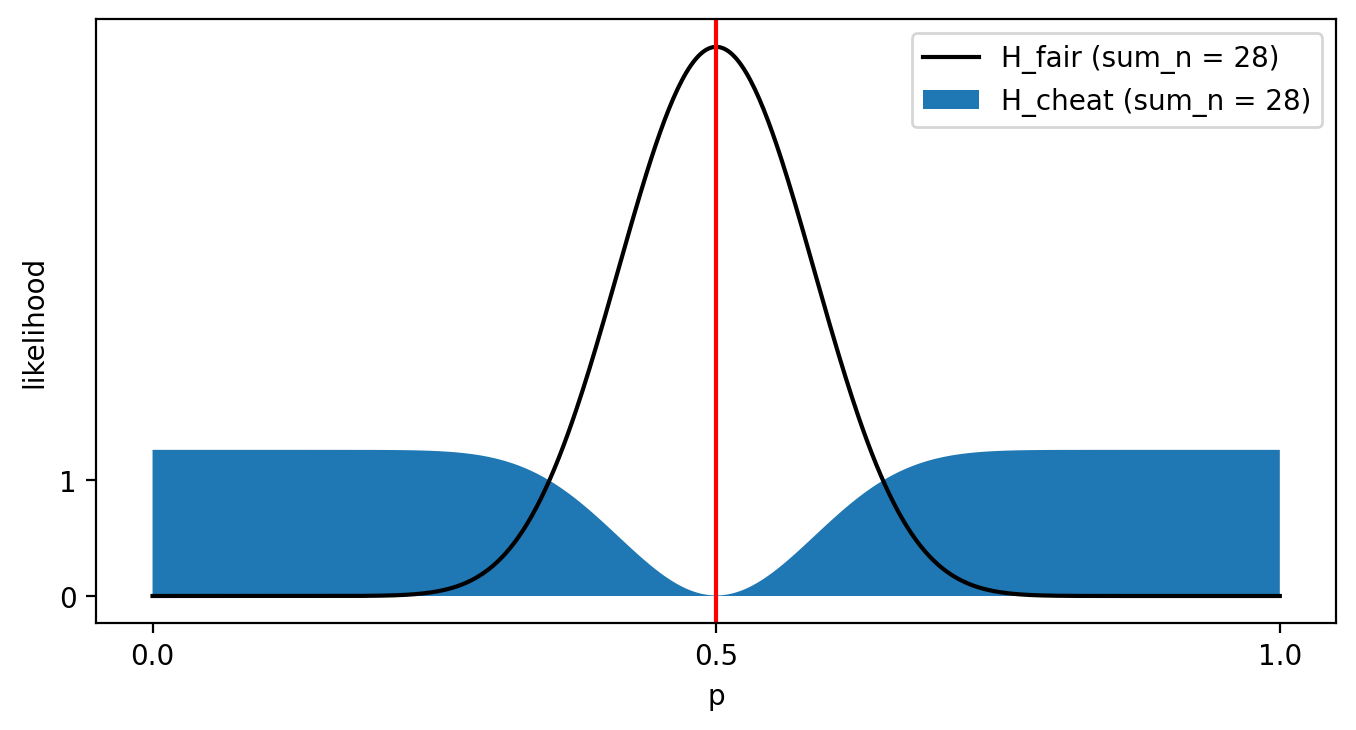

In [15]:
random  = np.random.default_rng(15)

k = 3     # number of Blaze rods needed
c = 5     # number of runs to earn k Blaze rods

sum_k = k * c  # we already know this
sum_n = 0

for experiment in range(c):
    results = random.choice( 2, size=16 )
    while np.sum(results) < k:
        results = np.append( results, random.choice( 2, size=16 ) )
    sum_n += np.sum( np.cumsum( results ) < k ) + 1

my_prior = prior(0.5, 4)

    
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

x = np.linspace(0,1,512)
m = (my_prior[0] + sum_n/2 - 1) / (sum(my_prior) + sum_n - 2)
M = beta.pdf( m, my_prior[0] + sum_n/2, my_prior[1] + sum_n/2)
plt.fill_between( x, (M - beta.pdf( x, my_prior[0] + sum_n/2, my_prior[1] + sum_n/2) + (.5/sum_n))/(M-1+(.5/sum_n)), \
         label=f'H_cheat (sum_n = {sum_n})')

plt.plot( x, beta.pdf( x, my_prior[0] + sum_n/2, my_prior[1] + sum_n/2), '-k', label=f'H_fair (sum_n = {sum_n})')
plt.axvline( 0.5, color='red' )


plt.xticks([0,.5,1])
plt.xlabel('p')

plt.yticks([0,1])
plt.ylabel('likelihood')

plt.legend()
plt.show()

## Putting It All Together

We finally have enough math in place to calculate a Bayes factor.

\begin{align}
\text{BF} &= \frac{ \int_{p=0}^1 \text{Beta}(\alpha_\text{posterior}, \beta_\text{posterior}, p ) H_\text{fair}( p ~|~ \|\vec n\|_1 ) }{ \int_{p=0}^1 \text{Beta}(\alpha_\text{posterior}, \beta_\text{posterior}, p ) H_\text{cheat}( p ~|~ \|\vec n\|_1, r_\text{fair} ) } \\
\int_{p=0}^1 \text{Beta}(\alpha_\text{posterior}, \beta_\text{posterior}, p ) H_\text{cheat}( p ~|~ \|\vec n\|_1, r_\text{fair} ) &= \int_{p=0}^1 \text{Beta}(\alpha_\text{posterior}, \beta_\text{posterior}, p ) \frac{ M_\text{fair} + \frac 1 {2 \|\vec n\|_1} - \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|\vec n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|\vec n\|_1, p) }{M_\text{fair} + \frac 1 {2 \|\vec n\|_1} - 1} \\
{} &= \frac 1 {M_\text{fair} + \frac 1 {2 \|\vec n\|_1} - 1} \left( M_\text{fair} + \frac 1 {2 \|\vec n\|_1} - \int_{p=0}^1 \text{Beta}(\alpha_\text{posterior}, \beta_\text{posterior}, p ) H_\text{fair}( p ~|~ \|\vec n\|_1 ) \right) \\
\text{BF} &= \frac{ \left(M_\text{fair} + \frac 1 {2 \|\vec n\|_1} - 1\right) \int_{p=0}^1 \text{Beta}(\alpha_\text{posterior}, \beta_\text{posterior}, p ) H_\text{fair}( p ~|~ \|\vec n\|_1 ) }{ M_\text{fair} + \frac 1 {2 \|\vec n\|_1} - \int_{p=0}^1 \text{Beta}(\alpha_\text{posterior}, \beta_\text{posterior}, p ) H_\text{fair}( p ~|~ \|\vec n\|_1 ) } \label{eqn:BF_H_fair_H_cheat}
\end{align}

Notice that Equation \ref{eqn:BF_H_fair_H_cheat} uses the integral required to apply $H_\text{fair}$, so the function I wrote above can be recycled to make the implementation shorter.

In [16]:
def BF_H_fair_H_cheat( vec_k, vec_n, r_fair, a_prior, b_prior, sum_n_weight=0.5 ):
    """Calculate the Bayes factor associated with H_fair / H_cheat, given the posterior distribution defined by vec_n, vec_k, and the prior.
        Relies on mpmath to perform all calculations, which also means you can adjust the precision.
    
    Parameters
    ----------
    vec_k: A total or list containing the successful attempts at this task until it was completed.
    vec_n: A total or list containing the total attempts at this task until it was completed.
    r_fair: A float between 0 and 1 representing the probability of success predicted by H_fair.
    a_prior: A positive or zero float representing the alpha variable of the prior.
    b_prior: A positive or zero float representing the beta variable of the prior.
    sum_n_weight: A positive or zero float that's used to weight the ||vec_n|| component. Defaults to 1/2.
    
    Returns
    -------
    The Bayes factor, a likelihood and mpmath float in the range [0,infinity]. Values greater than 1 favour
       fairnes, values below 1 favour cheating."""
    
    from mpmath import fdiv, fmul, gammaprod, power
    
    # validate our one new variable
    assert sum_n_weight >= 0
    
    # rely on posterior_H_fair()'s assertions to validate the remaining inputs
    integral = posterior_H_fair( vec_k, vec_n, r_fair, a_prior, b_prior )
    
    # but we still need sum_n for calculations
    try:
        len_n = len(vec_n)
        n_is_list = True
    except TypeError:
        len_n = 1
        n_is_list = False  
                 
    if n_is_list:
        sum_n = sum(vec_n)
    else:
        sum_n = vec_n

    
    # invoke mpmath instead of python's functions, to discourage precision loss
    m = fdiv( a_prior + r_fair*sum_n - 1,  a_prior + b_prior + sum_n - 2 )
    M = fmul( gammaprod([a_prior + b_prior + sum_n], [a_prior + r_fair*sum_n,b_prior + (1-r_fair)*sum_n]), \
             fmul(power( m, a_prior + r_fair*sum_n - 1 ), power( 1-m, b_prior + (1-r_fair)*sum_n - 1 )) )

    return fdiv( fmul(M - 1 + sum_n_weight/sum_n, integral), M + sum_n_weight/sum_n - integral )

Let's validate `BF_H_fair_H_cheat()` against the toy example, as well.

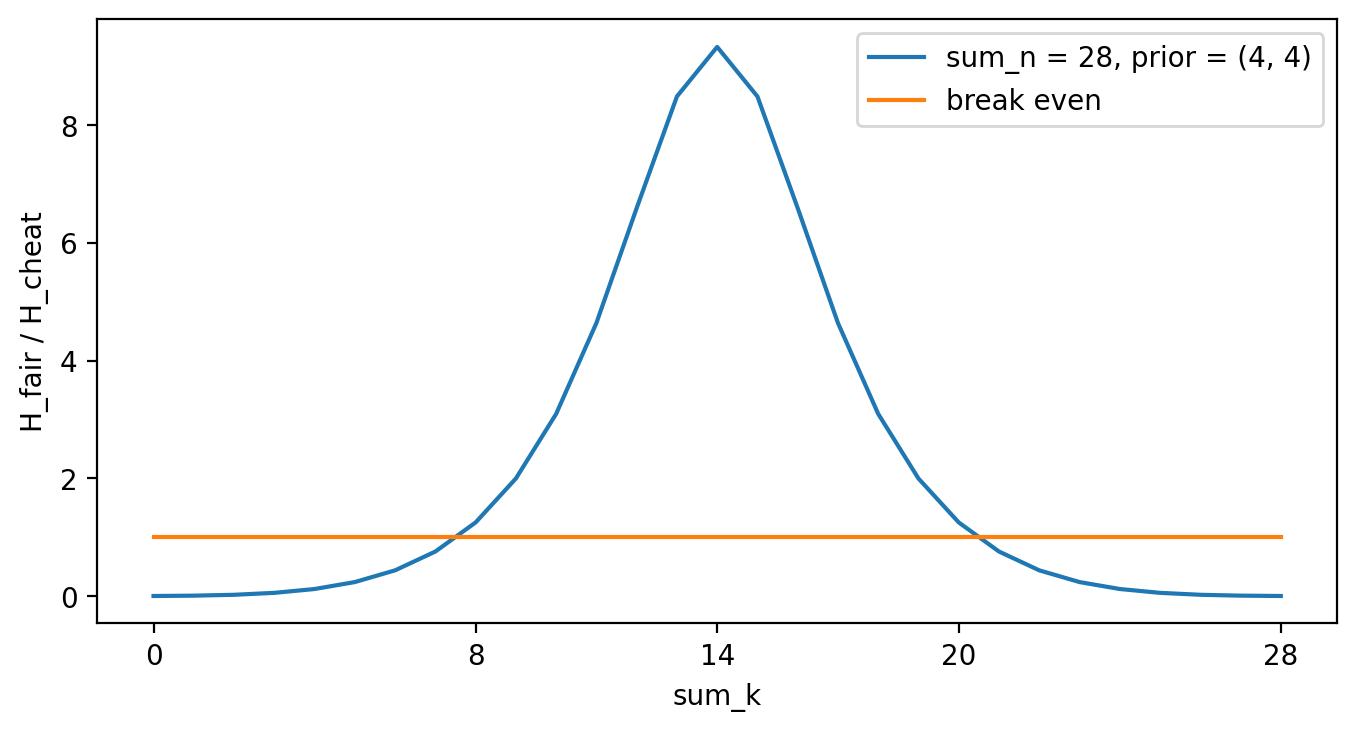

In [17]:
sum_n  = 28
r_fair = Fraction(1,2)
a_prior, b_prior = prior( r_fair, 4 )


fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

x = np.arange(sum_n + 1)
plt.plot( x, [BF_H_fair_H_cheat( v, sum_n, float(r_fair), a_prior, b_prior ) for v in x], '-', \
        label=f'sum_n = {sum_n}, prior = ({a_prior}, {b_prior})')
plt.plot( x, [1 for v in x], '-', \
        label='break even')

plt.ylabel("H_fair / H_cheat")
# plt.yscale('log')

plt.xlabel('sum_k')
plt.xticks([ 0, 8, 14, 20, 28 ])

plt.legend()
plt.show()

Figure \ref{fig:BF_posterior_H_fair} is as expected. The sharper peak than Figure \ref{fig:posterior_H_fair} is due to the increasing likelihood of $H_\text{cheat}$ given a $\|\vec k\|_1$ that diverges from perfect fairness. Values of $\|\vec k\|_1$ near $r_\text{fair}$ are nonetheless considered net evidence in favour of $H_\text{fair}$, while values far from there count as evidence for $H_\text{cheat}$. The crossover point is about six and a half possible values of $\|\vec k\|_1$ away from perfect fairness.

Another useful test is to fix $\|\vec k\|_1 = \frac 1 2 \|\vec n\|_1$ and increase $\|\vec n\|_1$. If you've done much frequentist analysis, you've noticed that a common scaling term is $\sqrt{n}$. This is a side-effect of the Central Limit Theorem applied to "well-behaved" distributions, where [it's been proven](https://en.wikipedia.org/wiki/Berry%E2%80%93Esseen_theorem) that estimates of true mean will converge to the true mean at a rate proportional to $\sqrt{n}$. We can think of that as metric of how strong the evidence is. Since Bernoulli processes fit in the definition of "well-behaved," our evidence for any fixed hypothesis should show the same scaling factor.

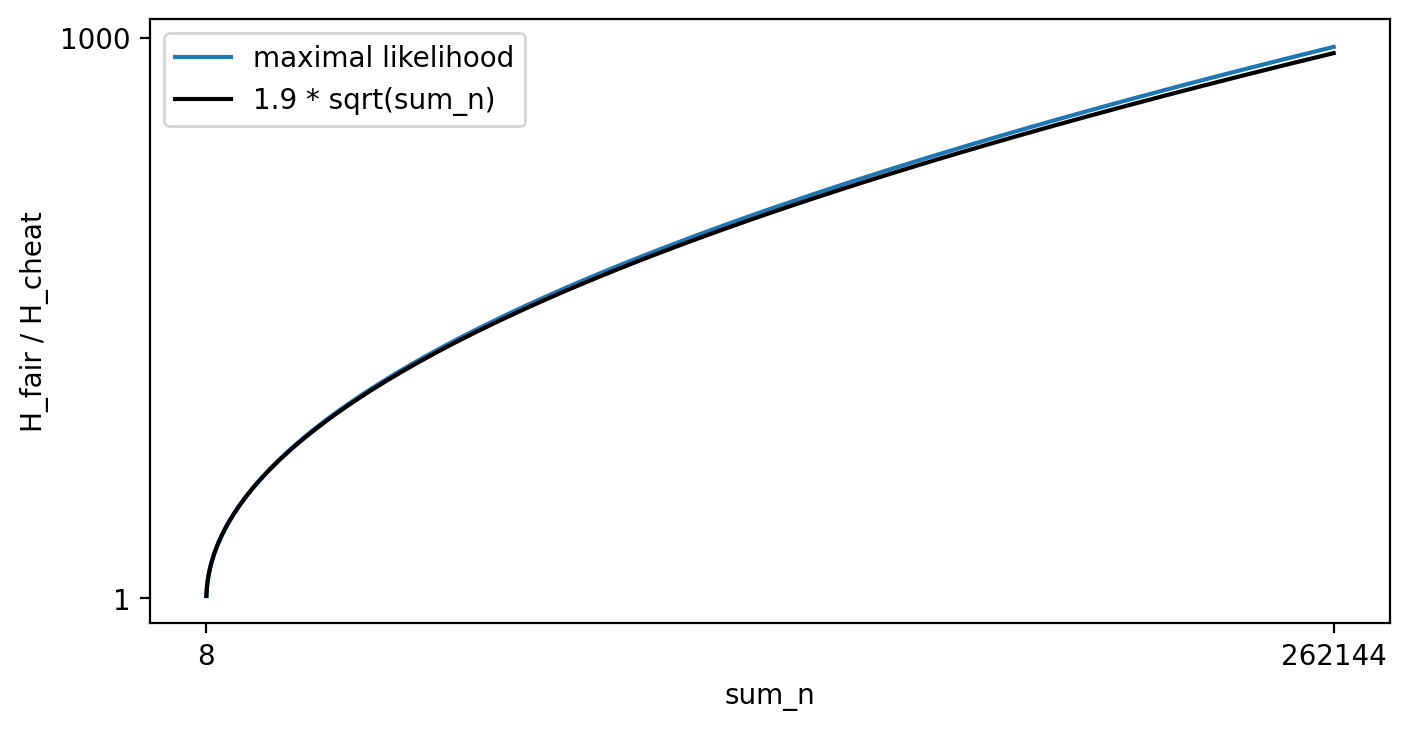

In [18]:
r_fair = 0.5
a_prior, b_prior = prior( r_fair, 4 )


fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

x = np.exp( np.linspace(np.log(8), np.log(1 << 18), 256) )
plt.plot( x, [BF_H_fair_H_cheat( v/2, v, float(r_fair), a_prior, b_prior ) for v in x], '-', \
        label=f'maximal likelihood')

plt.plot( x, 1.9*np.sqrt(x), '-k', label='1.9 * sqrt(sum_n)' )

plt.ylabel("H_fair / H_cheat")
plt.yticks([1, 1000])

plt.xlabel('sum_n')
plt.xticks([8, 1 << 18])

plt.legend()
plt.show()

As before, Figure \ref{fig:weight_evidence} holds no surprises. There is a subtle divergence between the theoretical and practical behavior of the Bayes factor. This is likely due to the $\frac 1 2 \|\vec n\|_1^{-1}$ term adding some skew when it has a large value.